In [1]:
from torch.optim import Adam
from gpytorch.optim import NGD
from experiments.partial import build_partial, plot_partial
from pathlib import Path
import numpy as np

from lafomo.datasets import DrosophilaSpatialTranscriptomics, HomogeneousReactionDiffusion
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.plot.misc import plot_variational_dist
from lafomo.utilities.torch import spline_interpolate_gradient, softplus

from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
drosophila = True

if drosophila:
    data = 'dros-kr'
    dataset = DrosophilaSpatialTranscriptomics(
        gene='kr', data_dir='../../../data', scale=False)
    params = dict(lengthscale=10,
                  sensitivity=0.0970,
                  decay=0.0764,
                  diffusion=0.0015,
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  zero_mean=False,
                  clamp=True)
else:
    data = 'toy-spatial'
    dataset = HomogeneousReactionDiffusion(data_dir='../../../data')
    params = dict(lengthscale=0.2,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  warm_epochs=-1,
                  dp=0.025,
                  natural=False,
                  clamp=False)

model_name = '0savedmodel'
model_name = 'epoch165'
model_name = 'model_with_3'
lfm, trainer, plotter = build_partial(
    dataset,
    params)#,
    # reload=f'../../../experiments/{data}/partial/{model_name}')

tx torch.Size([2, 512])
x dp is set to tensor(1., dtype=torch.float64)


/Users/jacob/Documents/proj/reggae/experiments/partial.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_target = torch.tensor(orig_data[trainer.t_sorted, 2])
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


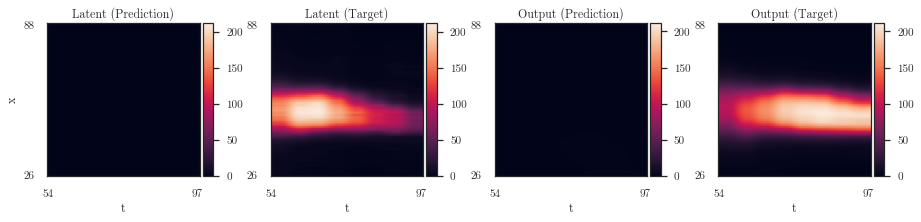

In [3]:
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

In [4]:
with torch.no_grad():
    lfm.gp_model.mean_module.constant += 50
    pass
print(lfm.gp_model.mean_module.constant)

Parameter containing:
tensor([[50.]], dtype=torch.float64, requires_grad=True)


8 64
torch.Size([8, 64])
64
torch.Size([1, 512])


/Users/jacob/Documents/proj/torchcubicspline/torchcubicspline/interpolate.py:277: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  ../aten/src/ATen/native/BucketizationUtils.h:25.)
  index = torch.bucketize(t.detach(), self._t) - 1
/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


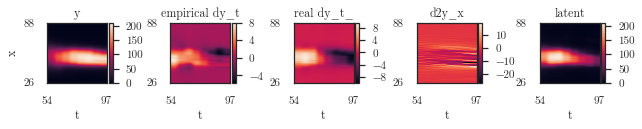

In [5]:
from lafomo.utilities.torch import inv_softplus
sensitivity = (torch.tensor(params['sensitivity']))
decay = (torch.tensor(params['decay']))
diffusion = (torch.tensor(params['diffusion']))
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
print(num_t, num_x)
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t, num_x)
print(y_matrix.shape)
dy_t = list()
for i in range(num_x):
    t = tx[0][::num_x]
    y = y_matrix[:, i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, _ = \
        spline_interpolate_gradient(t, y)
    dy_t.append(y_grad)
dy_t = torch.stack(dy_t)

# fig, axes = plt.subplots(nrows=2, figsize=(5, 7))
d2y_x = list()
dy_x = list()
for i in range(num_t):
    t = tx[1][:num_x]
    y = y_matrix[i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, y_grad_2 = \
        spline_interpolate_gradient(t, y)
    d2y_x.append(y_grad_2)
    # axes[0].plot(t_interpolate, y_interpolate)
    #
    # axes[1].plot(y_grad_2)
    dy_x.append(y_grad)

d2y_x = torch.stack(d2y_x)
dy_x = torch.stack(dy_x)[..., ::10, 0].reshape(1, -1)
d2y_x = d2y_x[..., ::10, 0].reshape(1, -1)
dy_t = dy_t[..., ::10, 0].t().reshape(1, -1)

def pde_func(y, u, sensitivity, decay, diffusion):
    # y (1, 1681) u (25, 1, 41, 41) s (25, 1)
    dy_t = (sensitivity * u.view(u.shape[0], -1) -
            decay * y.view(1, -1) +
            diffusion * d2y_x)
    return dy_t


orig_data = dataset.orig_data.squeeze().t()
orig_num_x = trainer.t_sorted.shape[0] // num_t
print(num_x)
u = orig_data[trainer.t_sorted, 2].view(num_t, -1)
u = u.view(1, -1)
print(u.shape)
dy_t_ = pde_func(
    trainer.y_target,
    u.repeat(25, 1),
    sensitivity.unsqueeze(0).repeat(25, 1),
    decay.unsqueeze(0).repeat(25, 1),
    diffusion.unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t, num_x).t(),
        dy_t.reshape(num_t, num_x).t(),
        dy_t_.view(num_t, num_x).t(),
        d2y_x.view(num_t, num_x).t(),
        torch.tensor(orig_data[trainer.t_sorted, 2]).view(num_t, -1).t(),
    ],
    extent, titles=['y', 'empirical dy_t', 'real dy_t_', 'd2y_x', 'latent']
)

In [6]:
train_ratio = 0.3
num_training = int(train_ratio * tx.shape[1])
if params['natural']:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]


pre_estimator = PartialPreEstimator(
    lfm, optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=dy_t.t(),
    train_mask=trainer.train_mask
)

In [7]:
import time
t0 = time.time()
lfm.pretrain(True)
lfm.config.num_samples = 50
times = pre_estimator.train(100, report_interval=5)
lfm.config.num_samples = 5

Epoch 001/100 - Loss: 1798.16 (1798.11 0.04) kernel: [[[22.03918885 18.21734585]]]
Epoch 006/100 - Loss: 1397.50 (1396.90 0.60) kernel: [[[22.28185225 17.96914035]]]
Epoch 011/100 - Loss: 1094.10 (1093.22 0.88) kernel: [[[22.47030219 17.72609924]]]
Epoch 016/100 - Loss: 864.64 (863.59 1.05) kernel: [[[22.61542476 17.48846285]]]
Epoch 021/100 - Loss: 697.03 (695.88 1.15) kernel: [[[22.69661438 17.26014691]]]
Epoch 026/100 - Loss: 569.31 (568.16 1.15) kernel: [[[22.7419096  17.04531997]]]
Epoch 031/100 - Loss: 472.81 (471.68 1.14) kernel: [[[22.76138145 16.85196243]]]
Epoch 036/100 - Loss: 403.34 (402.22 1.12) kernel: [[[22.76163518 16.68143509]]]
Epoch 041/100 - Loss: 346.16 (345.07 1.09) kernel: [[[22.75091491 16.51620971]]]
Epoch 046/100 - Loss: 302.49 (301.47 1.02) kernel: [[[22.74183853 16.35208663]]]
Epoch 051/100 - Loss: 268.92 (267.98 0.94) kernel: [[[22.69768208 16.19049642]]]
Epoch 056/100 - Loss: 241.04 (240.18 0.86) kernel: [[[22.63604284 16.03809886]]]
Epoch 061/100 - Loss: 

(100, 2)


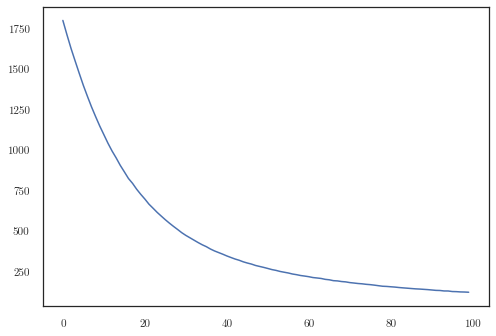

In [8]:
print(np.stack(times).shape)
plt.plot(np.stack(times)[:, 1])

In [ ]:
lfm.eval()
u = lfm.gp_model(trainer.tx.t()).sample(torch.Size([5])).permute(0, 2, 1)
dy_t_ = pde_func(
    trainer.y_target,
    u,
    sensitivity.unsqueeze(0).repeat(5, 1),
    decay.unsqueeze(0).repeat(5, 1),
    diffusion.unsqueeze(0).repeat(5, 1))[0]

latent = torch.tensor(orig_data[trainer.t_sorted, 2]).unsqueeze(0)
latent = latent.repeat(lfm.config.num_samples, 1, 1)
print(latent.shape)
latent = latent.view(lfm.config.num_samples, 1, num_t, num_x)
real = lfm.solve_pde(latent).mean(0)
unreal = lfm.solve_pde(u.view(5, 1, num_t, num_x)).mean(0)

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t, num_x).t(),
        dy_t.reshape(num_t, num_x).t(),
        dy_t_.view(num_t, num_x).t(),
        latent[0].view(num_t, -1).t(),
        u.mean(0).view(num_t, num_x).t(),
    ],
    extent, titles=['y', 'target dy_t', 'pred dy_t_', 'target latent', 'pred latent']
)
plot_spatiotemporal_data(
    [
        real.t().detach(),
        unreal.t().detach()
    ],
    extent, titles=['real', 'unreal']
)
print([softplus(param).item() for param in lfm.fenics_parameters])

Mean output variance: 2.4699514667998486
Test loss: 185.9607211579436
Q2: 0.181
Epoch 101/150 - Loss: 72.79 (67.28 5.51) kernel: [[[7.0070181  7.29201115]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Mean output variance: 3.2995598472423175
Test loss: 183.39679626246323
Q2: 0.159
Epoch 111/150 - Loss: 72.18 (66.13 6.04) kernel: [[[6.8961123  7.16708947]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Mean output variance: 1.1685222088361324
Test loss: 173.8182093752536
Q2: 0.174
Epoch 121/150 - Loss: 68.62 (62.33 6.29) kernel: [[[6.96764903 7.05083909]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Mean output variance: 1.6339688096329974
Test loss: 166.8937803267836
Q2: 0.179
Epoch 131/150 - Loss: 65.86 (59.73 6.12) kernel: [[[7.04927081 7.0389957 ]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Mean output variance: 2.5974826101109527
Test loss: 160.1770152521178
Q

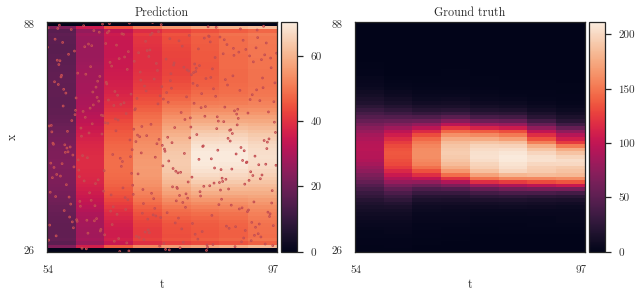

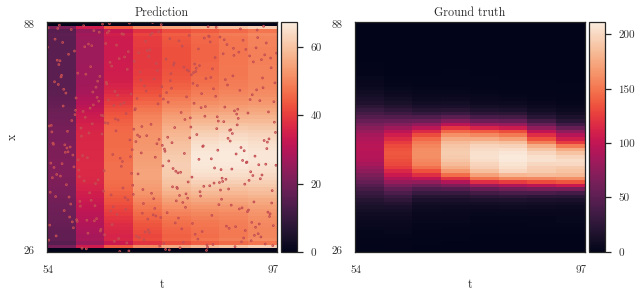

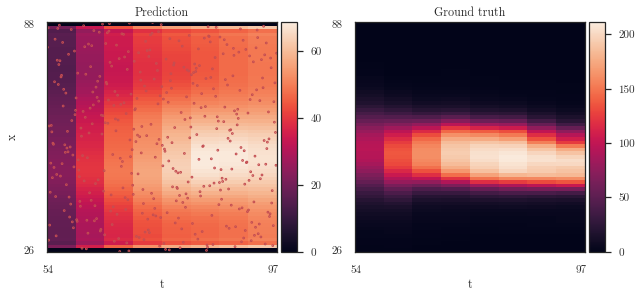

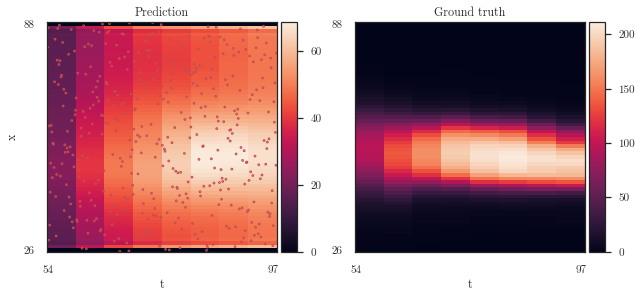

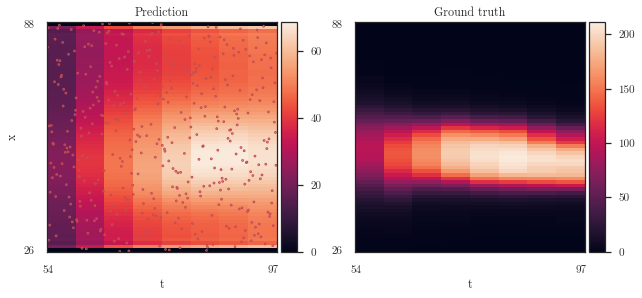

In [37]:
trainer.plot_outputs = True
lfm.pretrain(False)
trainer.train(50, report_interval=10);

In [17]:
for key in trainer.parameter_trace.keys():
    params = torch.stack(trainer.parameter_trace[key])
    for i in range(1, params.ndim):
        params = params.mean(-1)
    # plt.figure()
    # plt.plot(params)

In [21]:
print(lfm.gp_model.mean_module.constant)
[softplus(param) for param in lfm.fenics_parameters]

Parameter containing:
tensor([[46.2447]], dtype=torch.float64, requires_grad=True)


[tensor([[0.0970]], dtype=torch.float64),
 tensor([[0.0764]], dtype=torch.float64),
 tensor([[0.0015]], dtype=torch.float64)]

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


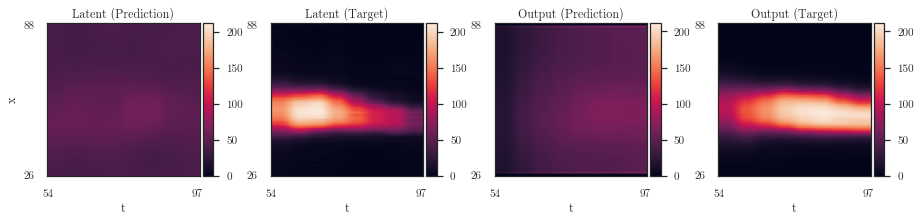

In [22]:
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

In [ ]:
xy = lfm.gp_model.variational_strategy.base_variational_strategy.inducing_points.squeeze()
# # c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_vec
# c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean
a = dict(lfm.named_parameters())
k = a['gp_model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar'].squeeze()
k = torch.matmul(k, k)
plt.imshow(k.detach())
plt.colorbar()
plt.figure()
mean = a['gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean'].squeeze().detach()
plt.plot(mean)
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1], c=mean)
plt.colorbar()

Parameter containing:
tensor([[28.3041]], dtype=torch.float64, requires_grad=True)
torch.Size([1, 512])


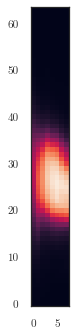

In [37]:
print(lfm.gp_model.mean_module.constant)
print(trainer.y_target.shape)
plt.imshow(trainer.y_target.view(8, 64).t(), origin='lower')
